## Registering Drone Dataset for Detectron2 models

The dataset is available for download here: https://www.kaggle.com/bulentsiyah/semantic-drone-dataset. For the purposes of this notebook, the dataset has been reuploaded to S3, fully preserving it's folder structure. 

Let's download it locally.

In [5]:
! aws s3 cp s3://d2-blog/ . --recursive

In [9]:
# check downloaded folder
! ls -al semantic_drone_dataset/

total 32
drwxrwxr-x 4 ec2-user ec2-user  4096 Jun 14 16:53 .
drwxrwxr-x 9 ec2-user ec2-user  4096 Jun 14 16:57 ..
drwxrwxr-x 2 ec2-user ec2-user 12288 Jun 14 16:53 label_images_semantic
drwxrwxr-x 2 ec2-user ec2-user 12288 Jun 14 16:53 original_images


## Install Detectron2

To run this notebook, you will need to have detectron2 installed locally on notebook instance. In case of Sagemaker Managed Notebooks with GPU devices (e.g. p3 family), feel free to use install instructions below:
1. Open sepearate terminal window and run `source activate pytorch_p36` command.
2. Install newer version of gcc in order to compile detectron2 locally: `sudo yum install gcc72 gcc72-c++`
3. Select a new version of gcc to be default compiler: `sudo update-alternatives --config gcc`
3. `conda install pytorch torchvision -c pytorch`
4. `pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'`
5. `pip install 'git+https://github.com/facebookresearch/fvcore'`
6. `export FORCE_CUDA="1"`
7. `export TORCH_CUDA_ARCH_LIST="Volta"`
8. `pip install 'git+https://github.com/facebookresearch/detectron2.git'`


We will use re-use parsing scripts for cityscapes dataset. Hence, need to install it too:

9. `python -m pip install cityscapesscripts`

In [14]:
import detectron2 # check that detectron2 was properly installed

## Dataset preparations

Detectron2 includes set of utilities for dataloading and vizualization. Check this [Cityscape sample](https://detectron2.readthedocs.io/_modules/detectron2/data/datasets/cityscapes.html) to get genereal idea.

We'll follow the same approach to process Drone Segmentation. Let's review custom scripts.

In [2]:
! pygmentize drone_dataset_processing.py

import logging
import numpy as np
import os
from fvcore.common.file_io import PathManager
from PIL import Image

from detectron2.utils.logger import setup_logger
from collections import namedtuple

try:
    import cv2  # noqa
except ImportError:
    # OpenCV is an optional dependency at the moment
    pass


logger = logging.getLogger(__name__)

# Following approach from Cityscapes Scripts: https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
         

## Visualize dataset

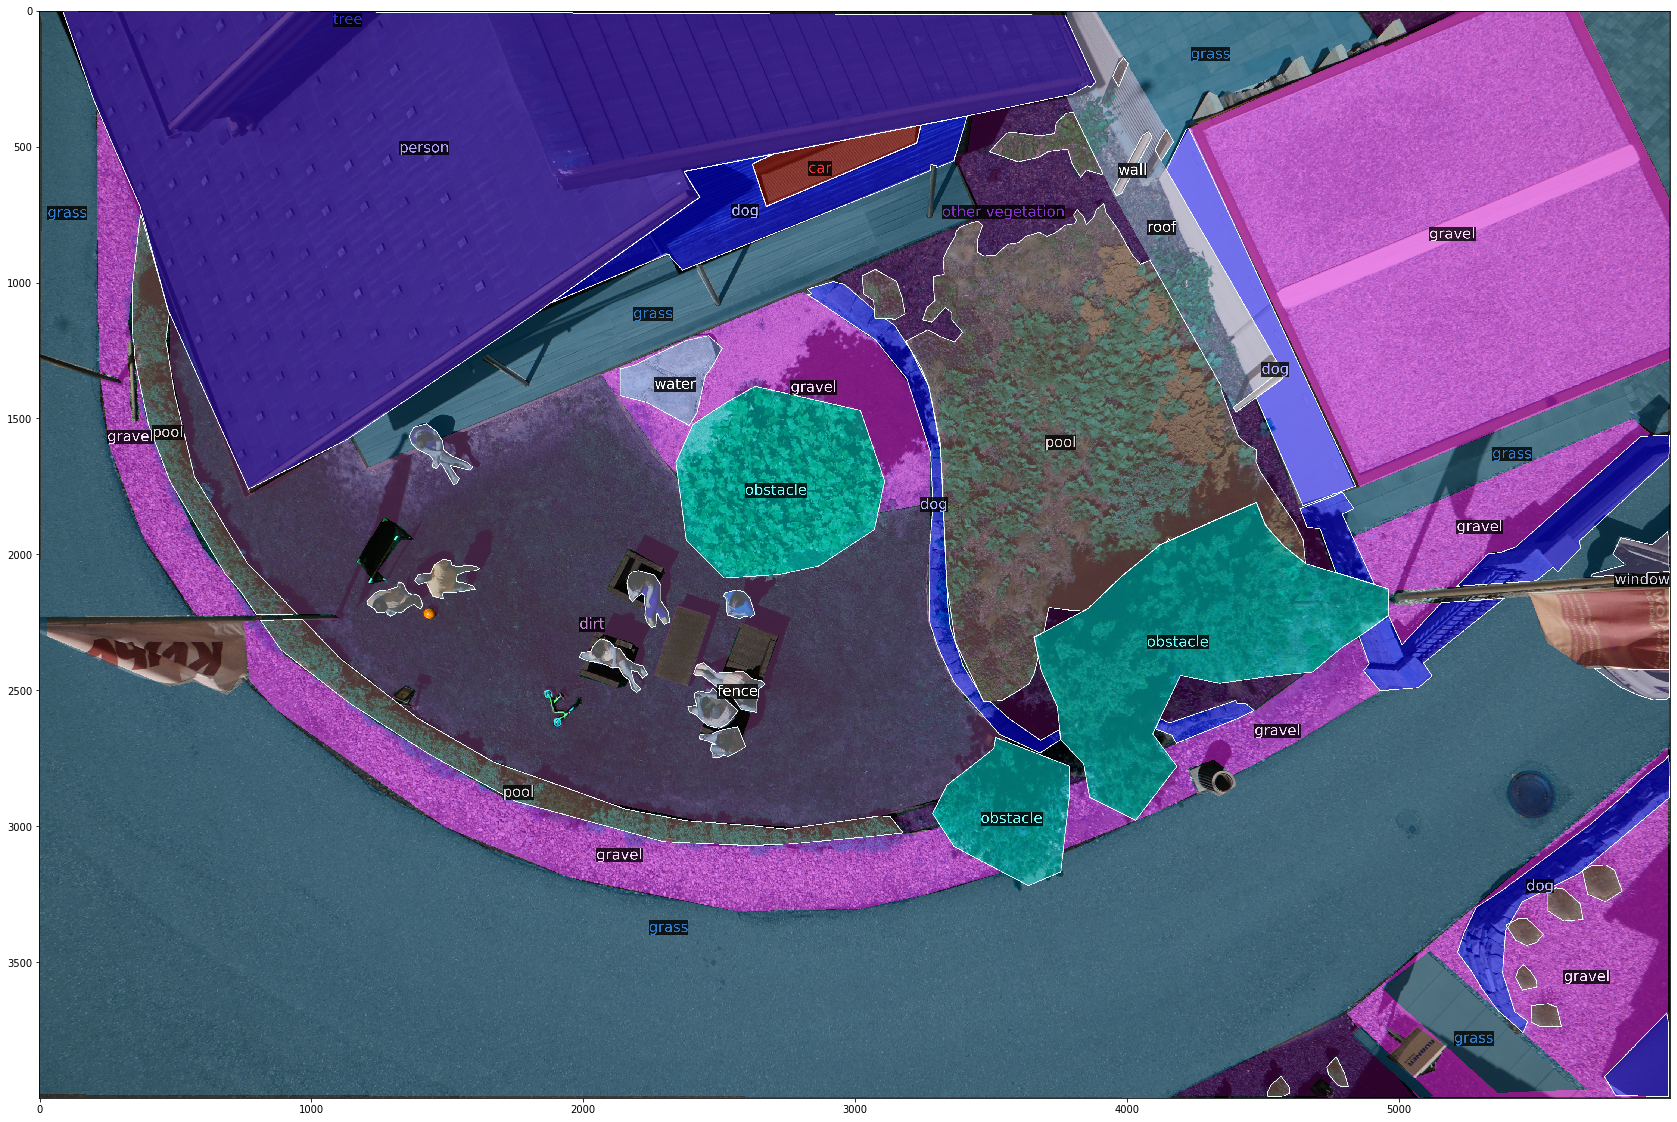

In [4]:
from detectron2.data.catalog import Metadata
from detectron2.utils.visualizer import Visualizer
import os
import numpy as np
from PIL import Image
from fvcore.common.file_io import PathManager
import cv2
from matplotlib import pyplot as plt
# from IPython.display import Image

from drone_dataset_processing import load_drone_semantic, labels

dirname = "drone-data-vis"
os.makedirs(dirname, exist_ok=True)

dicts = load_drone_semantic(
    "semantic_drone_dataset/original_images/", 
    "semantic_drone_dataset/label_images_semantic/")

stuff_colors = [k.color for k in labels if k.trainId != 255]
stuff_classes = [k.name for k in labels if k.trainId != 255]
meta = Metadata().set(stuff_colors=stuff_colors, stuff_classes=stuff_classes)


import random
d = random.choice(dicts)

img = np.array(Image.open(PathManager.open(d["file_name"], "rb")))
visualizer = Visualizer(img, metadata=meta)
vis = visualizer.draw_dataset_dict(d)
overlay_im = vis.get_image()[:, :, ::-1]
plt.figure(figsize = (30,20))
plt.imshow(overlay_im)

## Known issues

1. Mapping of label ids to labels. Currently, there is mismatch label name and pixel labels. This needs to be fixed in drone_processing.py
2. Total number of classes? Site states it 20, but is there, for instance, "unlabeled dataset"?